In [2]:
# import some libraries we'll need
import numpy as np
from matplotlib import pyplot as plt
import torch

Suppose we have a neural network with two inputs, two hidden layers of 8 units each, ReLU activations (except for $\hat y = f_\text{out}(h_L)$) and one output.

* Write an algorithm using python to compute the NN output $\hat y$ given the input and the free parameters (weights and biases)
* Write an algorithm to compute derivatives of the least squares loss $(y - \hat y)^2$ with respect to all free parameters of the NN. This should be a python function that takes the free parameters, NN inputs $x$ and NN training targets $y$ as its own inputs. **Don't use automatic differntiation, finite differences or symbolic math tools: do the derivatives by hand!**
* **Optional challenge problem (+25% of assignment max. points), skip for now if you get stuck**: Extend your derivative computation algorithm to work with any number of hidden layers, all of which can have different numbers of hidden units.

In [ ]:
import numpy as np

def initialize_parameters(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    weights -- python dictionary containing your weights "W1", "W2", ..., "WL"
    biases -- python dictionary containing your biases "b1", "b2", ..., "bL"
    """
    
    np.random.seed(3)  # Ensure reproducibility
    weights = {}
    biases = {}
    L = len(layer_dims)  # Number of layers in the network

    for l in range(1, L):
        weights['W' + str(l)] = np.random.randn(layer_dims[l-1], layer_dims[l]) * np.sqrt(2. / layer_dims[l-1])
        biases['b' + str(l)] = np.zeros((layer_dims[l],))
        
    return weights, biases

def relu(x):
    return np.maximum(0, x)

def derivative_relu(x):
    return np.where(x <= 0, 0, 1)

def compute_nn_output(X, weights, biases):
    # Forward pass
    H1 = relu(np.dot(X, weights['W1']) + biases['b1'])
    H2 = relu(np.dot(H1, weights['W2']) + biases['b2'])
    y_hat = np.dot(H2, weights['W3']) + biases['b3']
    Hl=[H1,H2]
    return y_hat,weights,biases,Hl

def backward_propagation(y, y_hat, weights,Hl, activations):
    # Initialize gradients dictionary
    gradients = {}
    L=weights.shape[1]
    # Compute gradient of the loss with respect to y_hat
    d_loss_dy_hat = (-2 * (y - y_hat)).T*weights[L]
    d_loss_dbL = d_loss_dy_hat * derivative_relu(weights[L]*Hl[0]+biases[L])
    d_loss_dwL = d_loss_dy_hat * derivative_relu(weights[L]*Hl[0]+biases[L]) * Hl[0].T
    
    # Backward pass for each layer
    for l in reversed(range(1, L+1)):  # Assuming L layers, excluding input layer
        # Compute gradient of loss with respect to weights and biases of layer l
        # This is a simplified representation; actual computation depends on activations and previous gradients
        gradients['W' + str(l)] = d_loss_dy_hat*  # Compute based on d_loss_dy_hat and chain rule
        gradients['b' + str(l)] = ...  # Compute based on d_loss_dy_hat
        
        # Update d_loss_dy_hat for the next layer (layer l-1)
        d_loss_dy_hat = ...  # Update based on gradients and ReLU derivative if applicable
    
    return gradients

def update_parameters(weights, biases, gradients, learning_rate):
    # Assuming there are 3 layers as per the provided structure
    L = 3  # Number of layers including input layer
    
    # Update weights and biases for each layer
    for l in range(1, L+1):
        weights['W' + str(l)] -= learning_rate * gradients['W' + str(l)]
        biases['b' + str(l)] -= learning_rate * gradients['b' + str(l)]
    
    return weights, biases

# Example weights and biases initialization
weights = {
    'W1': np.random.randn(2, 8),
    'W2': np.random.randn(8, 8),
    'W3': np.random.randn(8, 1)
}

biases = {
    'b1': np.random.randn(8),
    'b2': np.random.randn(8),
    'b3': np.random.randn(1)
}
# Example usage
layer_dims = [2, 8, 8, 1]  # 3-layer model
weights, biases = initialize_parameters(layer_dims)
# Example input
X = np.array([[0.5, -0.2]])

# Compute NN output
y_hat = compute_nn_output(X, weights, biases)
print("NN output:", y_hat)

We'll now download a data file and extract 3 variables. Each is a NumPy array:
* 'y' contains monthly values of the [Nino 3.4 ENSO index](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni), describing the [El Nino Southern Oscillation](https://en.wikipedia.org/wiki/El_Ni%C3%B1o%E2%80%93Southern_Oscillation) over time.
* `x` contains empirical orthogonal function coefficients that describe the ocean temperature at the sea surface and the depth average over the top 300 meters, in the Indo-Pacific, North-Pacific and Atlantic regions. Essentially, the numbers in each row of $x$ summarize temperatures in the upper ocean across the globe. For details of how these are calculated, you can consult [this paper](https://www.nature.com/articles/s41586-019-1559-7) by Ham et al. Each row of `x` describes the ocean state 2 months before the corresponding element of `y`.
* `t` contains the time in months since Jan. 1 1970 for each value of `y`. We can use this for plotting results but it won't appear in our calculations otherwise.

In [ ]:
# library for downloading files from google drive.
!pip install gdown

# download the data
!gdown https://drive.google.com/uc?id=1FUb-2lcAd0Y1ULjx5jB6UTMNDmGy3vZA

In [3]:
# load the data
with np.load('enso_and_pca.npz') as data:
    t, x, y = data['t'], data['x'], data['y']

Normalize `y` and each column of `x` so they all have a mean of zero and a standard deviation of one. Overwrite the original variables `x,y` with the normalized ones, but keep track of what you've done, so you can convert your predictions back into original data units later on if needed.

In [4]:
mx, my = x.mean(axis=0), y.mean()
sx, sy = x.std(axis=0), y.std()
x, y = (x - mx) / sx, (y - my) / sy


Last time we wrote a loop by hand to cycle over the data. However, pytorch provides great utilities to do this for us, which will let us focus on what's new in each lesson instead. In particular, we're going to use the PyTorch Dataset and DataLoader classes.

In [5]:
from torch.utils.data import TensorDataset, DataLoader

# create PyTorch tensors for our inputs and target outputs
xt = torch.tensor(x)
yt = torch.tensor(y)

# use the first 1100 time points as training data
train_size = 1100
xt_train, yt_train = xt[:1100], yt[:1100]

# save the remaining data for testing
test_size = len(xt[1100:])
xt_test, yt_test = xt[1100:], yt[1100:]

dataset = TensorDataset(xt_train, yt_train)  # combine the inputs and outputs into a PyTorch Dataset object
# create a dataloader to serve up batches of 8 data point for training
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)

Now let's get the first 'batch' of data from the dataloader, and see what it looks like.

In [6]:
for x_batch, y_batch in data_loader:
    print('shape of x_batch: {0}'.format(x_batch.shape) )
    print('shape of y_batch: {0}'.format(y_batch.shape) )
    break  # if we didn't have this line, the for loop would cycle through all the data

shape of x_batch: torch.Size([8, 46])
shape of y_batch: torch.Size([8])


Now use a for loop, iterating over batches from the data loader, to fit a linear regression $\hat y = x\cdot \beta$ with least squares loss, by stochastic gradient descent. Refer back to the code you wrote from the last set of exercises for guidance (and feel free to copy-paste from your own previous homework).
* Add an extra column of ones to `x` to incorporate a constant term
* Don't forget to set `requires_grad = True` when initializing `beta`
* Choose how to initialize $\beta$. All zeros? Random? Does it make much of a difference here?
* As before, don't forget to use `with torch.no_grad():` when updating parameters
* Store the loss at each iteration of the loop.
* Does the loss decrease on the training data? Do you get a positive correlation between $y$ and $\hat y$ at the end on the training data?
* See if you can get a better result by adjusting the initialization of free parameters or the learning rate

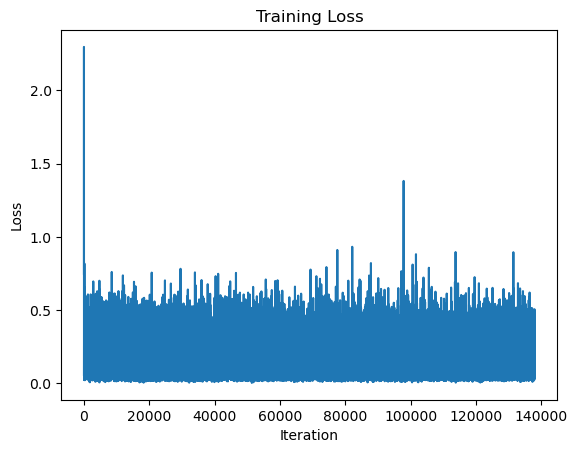

In [7]:
import torch

# Linear Regression with Gradient Descent
beta = torch.zeros((x.shape[1] + 1, 1), requires_grad=True)  # Including intercept
learning_rate = 1e-2
losses = []

for epoch in range(1000):
    for x_batch, y_batch in data_loader:
        x_batch = torch.cat([x_batch, torch.ones((x_batch.shape[0], 1))], dim=1)
        y_pred = x_batch @ beta
        loss = torch.mean((y_pred - y_batch.view(-1, 1)) ** 2)
        losses.append(loss.item())
        
        loss.backward()
        
        with torch.no_grad():
            beta -= learning_rate * beta.grad
            beta.grad.zero_()

# Plot the loss over iterations
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


Now repeat the process, but instead of a linear model we'll use a neural network with two hidden layers of 32 units each, and the ReLU activation function $\phi(z) = \max(0, z)$. Again we'll use least squares loss and a batch size of 8.

**Don't** use PyTorch's built-in classes for this just yet. Instead:
* Define tensors of the correct size and data type (check `x.dtype`) for each variable containing free parameters (weights and biases) of your neural network. Remember to set `requires_grad = True` where needed.
* For each batch of data, compute the hidden state activations $h_1$ as a function of $W_1, b_1, x$
* Then compute $h_2$, $\hat y$ and $e=\ell(y, \hat y)$.
* Call `e.backward()` to compute derivatives of $e$ with respect to the free variables of your neural network, using backward-mode differentiation.
* Now update all free parameters based on the computed derivatives and the learning rate, just as you did for the linear regression example. Remember to use `with torch.no_grad():`
* Plot the convergence of the loss function over iterations. Are you getting a better fit than with the linear regression?
* How did you initialize? Does it make a difference now?

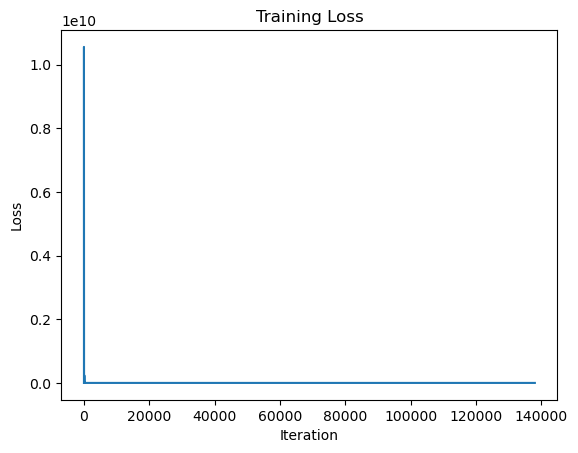

In [8]:
# Define neural network parameters
input_size = x.shape[1]
hidden_size = 32
output_size = 1

W1 = torch.randn((input_size, hidden_size), dtype=torch.float32, requires_grad=True)
b1 = torch.randn((hidden_size,), dtype=torch.float32, requires_grad=True)
W2 = torch.randn((hidden_size, hidden_size), dtype=torch.float32, requires_grad=True)
b2 = torch.randn((hidden_size,), dtype=torch.float32, requires_grad=True)
W3 = torch.randn((hidden_size, output_size), dtype=torch.float32, requires_grad=True)
b3 = torch.randn((output_size,), dtype=torch.float32, requires_grad=True)

# Training loop for the neural network
learning_rate = 1e-3
losses = []

for epoch in range(1000):
    for x_batch, y_batch in data_loader:
        # Forward pass
        h1 = torch.relu(x_batch @ W1 + b1)
        h2 = torch.relu(h1 @ W2 + b2)
        y_pred = h2 @ W3 + b3
        loss = torch.mean((y_pred - y_batch.view(-1, 1)) ** 2)
        losses.append(loss.item())
        
        # Backward pass
        loss.backward()
        
        with torch.no_grad():
            W1 -= learning_rate * W1.grad
            b1 -= learning_rate * b1.grad
            W2 -= learning_rate * W2.grad
            b2 -= learning_rate * b2.grad
            W3 -= learning_rate * W3.grad
            b3 -= learning_rate * b3.grad
            
            # Zero gradients
            W1.grad.zero_()
            b1.grad.zero_()
            W2.grad.zero_()
            b2.grad.zero_()
            W3.grad.zero_()
            b3.grad.zero_()

# Plot the loss over iterations
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


Now plot the target ENSO 3.4 index values $y$ against the predictions from the linear regression and the neural network. Clearly mark the boundary between training and testing data.

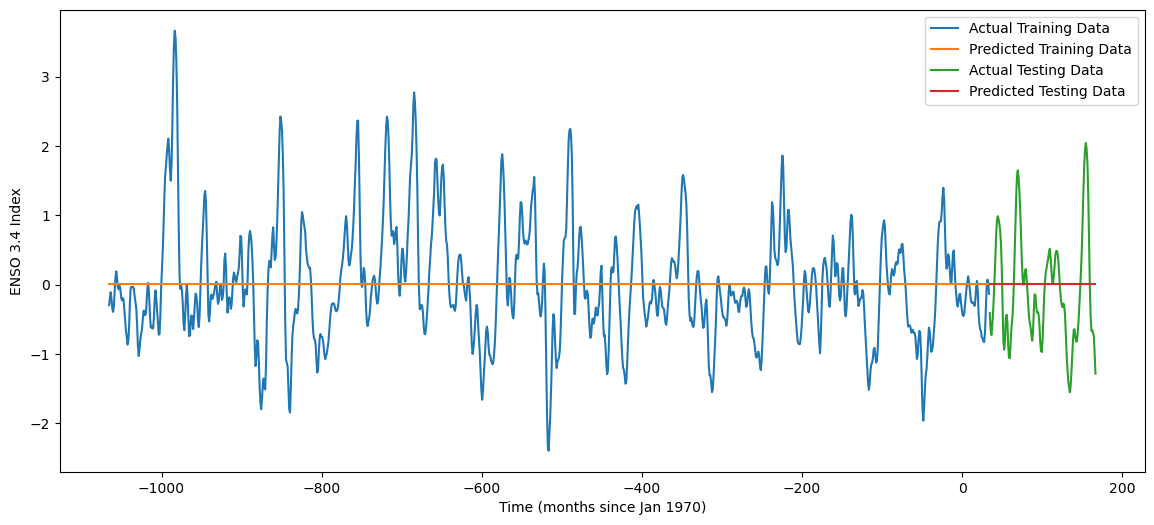

MSE (NN) on training data: 0.6955280303955078
MSE (NN) on testing data: 0.6357740163803101
Pearson correlation (NN) on training data: nan
Pearson correlation (NN) on testing data: nan


c:\Users\papas\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\papas\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [9]:
# Predictions on training and testing data
with torch.no_grad():
    # Training data
    h1_train = torch.relu(xt_train @ W1 + b1)
    h2_train = torch.relu(h1_train @ W2 + b2)
    y_train_pred = h2_train @ W3 + b3

    # Testing data
    h1_test = torch.relu(xt_test @ W1 + b1)
    h2_test = torch.relu(h1_test @ W2 + b2)
    y_test_pred = h2_test @ W3 + b3

# Convert predictions back to original scale
y_train_pred_original = y_train_pred.numpy() * sy + my
y_test_pred_original = y_test_pred.numpy() * sy + my

# Plot predictions vs actual values
plt.figure(figsize=(14, 6))
plt.plot(t[:1100], yt_train.numpy() * sy + my, label='Actual Training Data')
plt.plot(t[:1100], y_train_pred_original, label='Predicted Training Data')
plt.plot(t[1100:], yt_test.numpy() * sy + my, label='Actual Testing Data')
plt.plot(t[1100:], y_test_pred_original, label='Predicted Testing Data')
plt.xlabel('Time (months since Jan 1970)')
plt.ylabel('ENSO 3.4 Index')
plt.legend()
plt.show()




What are mean square errors for the NN and linear regression, in original data units, on the testing and training data? How about Pearson's correlation coefficient?

In [14]:
# Mean square error
mse_train_nn = np.mean((yt_train.numpy() * sy + my - y_train_pred_original) ** 2)
mse_test_nn = np.mean((yt_test.numpy() * sy + my - y_test_pred_original) ** 2)

# Pearson correlation coefficient
corr_train_nn = np.corrcoef(yt_train.numpy() * sy + my, y_train_pred_original.flatten())[0, 1]
corr_test_nn = np.corrcoef(yt_test.numpy() * sy + my, y_test_pred_original.flatten())[0, 1]

print(f'MSE (NN) on training data: {mse_train_nn}')
print(f'MSE (NN) on testing data: {mse_test_nn}')
print(f'Pearson correlation (NN) on training data: {corr_train_nn}')
print(f'Pearson correlation (NN) on testing data: {corr_test_nn}')

MSE (NN) on training data: 0.6955280303955078
MSE (NN) on testing data: 0.6357740163803101
Pearson correlation (NN) on training data: nan
Pearson correlation (NN) on testing data: nan


Now we'll do the same thing, but defining a python object class for our neural network, and some built-in PyTorch classes:

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, n_inputs=46, n_outputs=1, n_hidden=32):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(n_inputs, n_hidden)  # 5*5 from image dimension
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_outputs)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

As described in the first two lectures, we are now building our neural net out of composable functions that we can stack together like legos.

PyTorch also lets us iterate in loops over the trainable parameters of the model. Note how `requires_grad` was correctly set by default for the learnable parameters.

In [15]:
net = Net(n_hidden= 32)
for name, param in net.named_parameters():
    print(f'{name}: requires_grad={param.requires_grad}')

fc1.weight: requires_grad=True
fc1.bias: requires_grad=True
fc2.weight: requires_grad=True
fc2.bias: requires_grad=True
fc3.weight: requires_grad=True
fc3.bias: requires_grad=True


When we use our network object like a function, the input gets passed to the `forward()` method:

In [ ]:
print(net(torch.rand(46)))

We can also provide it with multiple inputs to process independently:

In [ ]:
print(net(torch.rand(4,46)))

Now redo the training loop from before, but now update the parameters using an inner loop over `net.named_parameters` (remember to use `torch.no_grad()` when updating parameters, and to zero out the derivatives after you do so).

Instead of calling `var.grad.zero()` on each trainable variable, we can now also simply call `net.zero_grad()` once.

Look up the default initialization of weights and biases in the `nn.Linear` objects you used.

In [ ]:
import torch

# Assuming net, loss_function, optimizer, and data_loader are defined
for epoch in range(num_epochs):
    for inputs, labels in data_loader:
        # Forward pass
        outputs = net(inputs)
        loss = loss_function(outputs, labels)
        
        # Zero the gradients
        net.zero_grad()
        
        # Backward pass
        loss.backward()
        
        # Update parameters manually
        with torch.no_grad():
            for name, param in net.named_parameters():
                if param.requires_grad:
                    param -= learning_rate * param.grad
        
        # Zero out the derivatives after updating
        net.zero_grad()


Change the `Net()` class above to allow an adjustable number of hidden layers to be specified when initializing the object, and to specify a different number of hidden units for each hidden layer. Can you get better results on the testing data by adjusting this?

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, n_inputs=46, n_outputs=1, hidden_layers=[32, 32]):
        super(Net, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.Linear(n_inputs, hidden_layers[0]))
        for i in range(1, len(hidden_layers)):
            self.hidden_layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
        self.output_layer = nn.Linear(hidden_layers[-1], n_outputs)
    
    def forward(self, x):
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        x = self.output_layer(x)
        return x

# Initialize network and print parameters
net = Net(hidden_layers=[32, 32])
for name, param in net.named_parameters():
    print(f'{name}: requires_grad={param.requires_grad}')

# Example forward pass
print(net(torch.rand(46)))
print(net(torch.rand(4, 46)))
